In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer # VADER https://github.com/cjhutto/vaderSentiment
from nltk import tokenize

In [5]:
df = pd.read_csv("Combined_News_DJIA.csv")
dj_df = pd.read_csv("DJIA_table.csv")
reddit_df = pd.read_csv("RedditNews.csv")

In [6]:
df.describe()
df.Date = pd.to_datetime(df.Date)
df.head()
df.index = df.Date

In [7]:
dj_df.describe()
dj_df.Date = pd.to_datetime(dj_df.Date)
dj_df.index = dj_df.Date
dj_df = dj_df.sort_values(by = 'Date', ascending=True)
dj_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,,
2008-08-08,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
2008-08-11,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2008-08-12,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
2008-08-13,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
2008-08-14,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [11]:
reddit_df.index = pd.to_datetime(reddit_df.Date)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# Create a single string for each date (since we only want to look at word counts)
news_combined = ''
for row in range(0,len(df.index)):
    news_combined+=' '.join(str(x).lower().strip() for x in df.iloc[row,2:27])
    
vectorizer = CountVectorizer()
news_vect = vectorizer.build_tokenizer()(news_combined)
word_counts = pd.DataFrame([[x,news_vect.count(x)] for x in set(news_vect)], columns = ['Word', 'Count'])

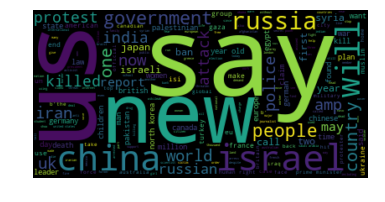

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(news_combined)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate('text')
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
plt.show()

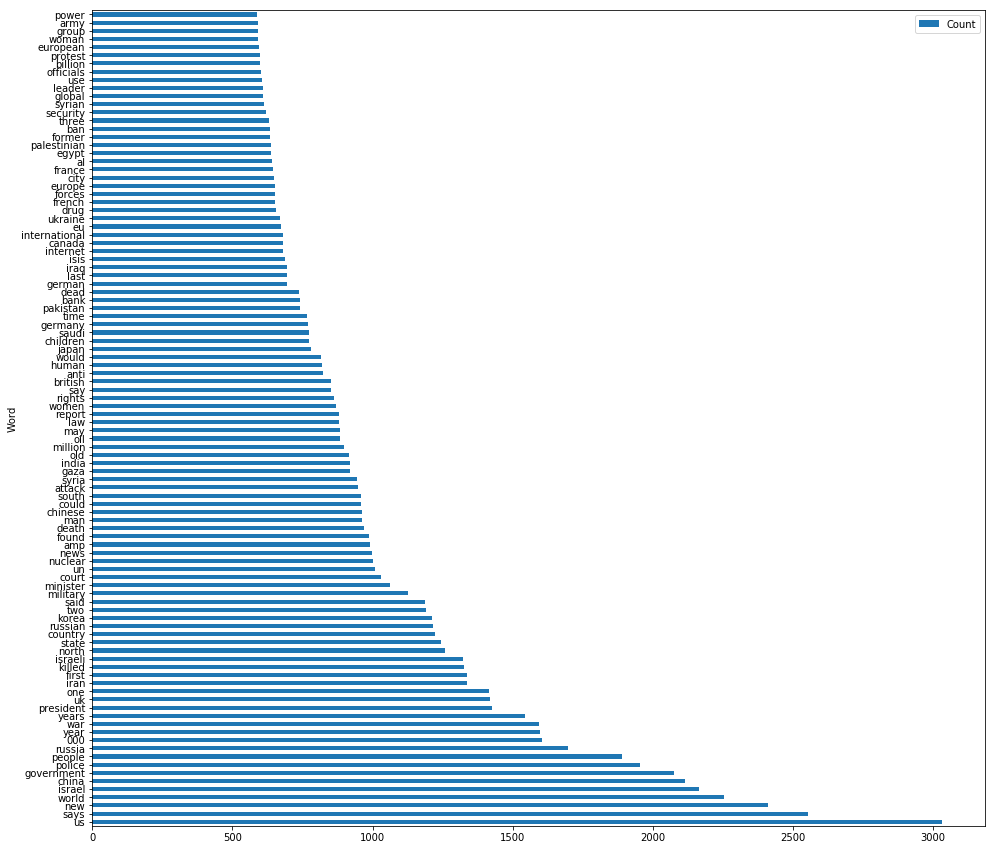

In [14]:
word_counts_adj = word_counts
word_counts_adj = word_counts_adj .reset_index(drop=True)

for i in word_counts['Word']:
    if i in stop:
        word_counts_adj = word_counts_adj.drop(word_counts_adj[word_counts_adj['Word'] == i].index)
        
word_counts_adj.index = word_counts_adj['Word']
counts = word_counts_adj.sort_values(by='Count', ascending=False)[0:100].plot(kind='barh', figsize = (16,15))
plt.show()

In [15]:
scores = pd.DataFrame(index = df.Date, columns = ['Compound', 'Positive', 'Negative', "Neutral"])

analyzer = SentimentIntensityAnalyzer() # Use the VADER Sentiment Analyzer

for j in range(1,df.shape[0]):    
    tmp_neu = 0
    tmp_neg = 0
    tmp_pos = 0
    tmp_comp = 0
    for i in range(2,df.shape[1]):
        text = df.iloc[j,i]
        if(str(text) == "nan"):
            tmp_comp +=  0
            tmp_neg += 0
            tmp_neu += 0
            tmp_pos += 0
        else:
            vs = analyzer.polarity_scores(df.iloc[j,i])
            tmp_comp +=  vs['compound']
            tmp_neg += vs['neg']
            tmp_neu += vs['neu']
            tmp_pos += vs['pos']
    
    scores.iloc[j,] = [tmp_comp, tmp_pos, tmp_neg, tmp_neu]

In [16]:
scores.head()
scores = scores.dropna()

In [17]:
scores.head()

,Compound,Positive,Negative,Neutral
Date,,,,
2008-08-11,-3.0185,1.677,3.757,19.565
2008-08-12,-5.4389,1.447,3.928,19.624
2008-08-13,-4.2181,1.043,3.624,20.333
2008-08-14,-3.2687,2.072,3.858,19.069
2008-08-15,-4.018,1.756,3.946,19.298


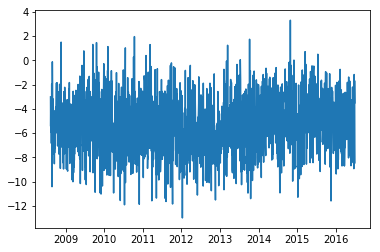

In [18]:
scores.index = scores.index.to_datetime()
plt.plot(scores.Compound)
plt.show()

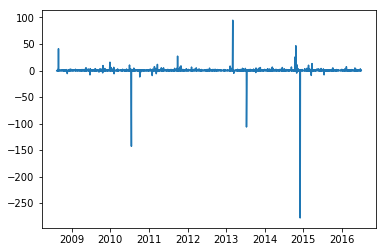

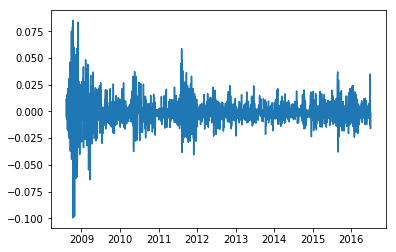

In [19]:
plt.plot(scores.index, scores.Compound.shift(1)/scores.Compound-1)
plt.show()

plt.plot(dj_df.Date, dj_df.Close.shift(1)/dj_df.Close-1)
plt.show()

In [20]:
merged = scores.join(df)
merged = merged.iloc[:, 0:6]
merged = merged.iloc[2:,]
merged = merged.dropna()
print merged

           Compound Positive Negative Neutral       Date  Label
Date                                                           
2008-08-13  -4.2181    1.043    3.624  20.333 2008-08-13      0
2008-08-14  -3.2687    2.072    3.858  19.069 2008-08-14      1
2008-08-15   -4.018    1.756    3.946  19.298 2008-08-15      1
2008-08-18  -5.1051    0.997    3.888  20.114 2008-08-18      0
2008-08-19  -6.8494    1.134    4.347  19.518 2008-08-19      0
2008-08-20  -4.0011    1.315    3.528  20.157 2008-08-20      1
2008-08-21  -5.9883    1.019    5.189  18.792 2008-08-21      1
2008-08-22  -1.9697    2.041    3.032  19.926 2008-08-22      1
2008-08-25 -10.4274    0.167    6.232  18.601 2008-08-25      0
2008-08-26  -7.3009    1.402    6.743  16.856 2008-08-26      1
2008-08-27  -5.1659    1.306    3.948  19.746 2008-08-27      1
2008-08-28  -0.1227    2.411    2.598  19.991 2008-08-28      1
2008-08-29  -1.4756    1.858    2.177  20.965 2008-08-29      0
2008-09-02  -6.1494    1.274     5.28  1

In [21]:
train = merged[merged.index < '2015-01-01']
test = merged[merged.index > '2014-12-31']
print train.head()
print test.head()

           Compound Positive Negative Neutral       Date  Label
Date                                                           
2008-08-13  -4.2181    1.043    3.624  20.333 2008-08-13      0
2008-08-14  -3.2687    2.072    3.858  19.069 2008-08-14      1
2008-08-15   -4.018    1.756    3.946  19.298 2008-08-15      1
2008-08-18  -5.1051    0.997    3.888  20.114 2008-08-18      0
2008-08-19  -6.8494    1.134    4.347  19.518 2008-08-19      0
           Compound Positive Negative Neutral       Date  Label
Date                                                           
2015-01-02  -6.3653    1.904     3.31  19.785 2015-01-02      1
2015-01-05  -6.1614    0.995    3.969  20.035 2015-01-05      0
2015-01-06  -4.4173    1.233    3.187  20.579 2015-01-06      0
2015-01-07  -5.6034     1.56    4.299   19.14 2015-01-07      1
2015-01-08 -11.2947    0.996    5.707  18.296 2015-01-08      1


In [22]:
basictrain = train['Compound']
# print basictrain
basictrain = basictrain.values.reshape(-1,1)
basicmodel = LogisticRegression(penalty = 'l1',C=0.2)
basicmodel = basicmodel.fit(basictrain, train["Label"])

In [23]:
basictest = test['Compound']
basictest = basictest.values.reshape(-1,1)
basicpredictions = basicmodel.predict(basictest)

In [24]:
print basicpredictions

[1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]


In [25]:
pd.crosstab(test["Label"], basicpredictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,3,183
1,4,188
